In [1]:
begin
  import Pkg
  Pkg.activate("..")
  Pkg.instantiate()

  push!(LOAD_PATH, "$(@__DIR__)/../src")
  include("./pointcloud_data.jl")

  using NoisyReach
  using Random
  using Plots
  using Statistics

  Random.seed!(123) # Setting the seed
end

  Activating project at `~/Downloads/sc/NoisyReach.jl`
Precompiling project...
   5747.0 ms  ✓ NoisyReach
  1 dependency successfully precompiled in 7 seconds. 380 already precompiled.


TaskLocalRNG()

In [2]:
const sys = benchmarks[:F1]
const N = 500

const x0 = 1000.0
const u0 = 0.0

const T = 10
const hc = 1e-4
const Hc = floor(Int, T / hc)

100000

In [3]:
experiment = ("casa", 10)

if length(ARGS) == 2
  experiment_name = ARGS[1]
  experiment_value = parse(Int, ARGS[2])
  experiment = (experiment_name, experiment_value)
end

In [4]:
hd = pointcloud_data[experiment[1]][experiment[2]]["h"]
Hd = floor(Int, T / hd)

72

In [5]:
@debug """-----BEGIN PARAMS-----
sys=$sys
N=$N
x0=$x0
u0=$u0
T=$T
hc=$hc
hd=$hd
Hc=$Hc
Hd=$Hd
-----END PARAMS-----"""

In [6]:
sys_c, K_c = synthesize(sys, hc)

x₀ = fill(x0, size(sys.A, 1))
xc, uc = simulate(sys_c, Hc, x₀, K_certain, K_c)
xc[end], uc[end]

([1.4674263761264608e-27, -1.5683352910220794e-27], [5.536680415273446e-28])

In [7]:
sys_d, K_d = synthesize(sys, hd)

z₀ = fill(x0, size(sys.A, 1))
xds, uds = unzip([simulate(sys_d, Hd, z₀, K_uncertain, K_d, pointcloud_data[experiment[1]][experiment[2]]["rel_err"]) for _ in 1:N])
xds[1][end], uds[1][end]

([-4.3032109247683186e-26, 4.7151004595140356e-26], [-3.3457447729572577e-26])

In [19]:
#rel_dev_trajs = [[(1 .- (xds[i][k] ./ xc[1+(k-1)*floor(Int,hd/hc)])) for k in 1:Hd] for i in 1:N]
dev_trajs = [[(xc[1+(k-1)*floor(Int,hd/hc)] .- xds[i][k]) for k in 1:Hd] for i in 1:N]
dev₁_trajs = [[dev[1] for dev in dev_traj] for dev_traj in dev_trajs]
uds₁ = [[udi[1] for udi in ud] for ud in uds]

mean_mean_dev₁ = mean([mean(abs.(dev₁_traj)) for dev₁_traj in dev₁_trajs])
max_max_dev₁ = maximum([maximum(abs.(dev₁_traj)) for dev₁_traj in dev₁_trajs])

mean_rmse_dev₁ = mean([std(dev₁_traj) for dev₁_traj in dev₁_trajs])
std_rmse_dev₁ = std([std(dev₁_traj) for dev₁_traj in dev₁_trajs])
max_rmse_dev₁ = maximum([std(dev₁_traj) for dev₁_traj in dev₁_trajs])

mean_mean_u₁ = mean([mean(abs.(ud₁)) for ud₁ in uds₁])
std_mean_u₁ = std([mean(abs.(ud₁)) for ud₁ in uds₁])
max_max_u₁ = maximum([maximum(abs.(ud₁)) for ud₁ in uds₁])

println("$(experiment[1]) @ $(experiment[2])")
println("mean_rmse_dev₁	std_rmse_dev₁	mean_mean_u₁	std_mean_u₁")
println("$mean_rmse_dev₁	$std_rmse_dev₁	$mean_mean_u₁	$std_mean_u₁")

┌ Info: -----BEGIN RESULTS-----
│ mean_rmse_dev₁	std_rmse_dev₁	mean_mean_u₁	std_mean_u₁
│ 48.114653386640164	27.82569280642622	14.333185591704435	4.535260489731549
└ -----END RESULTS-----


In [20]:
convergences = [first_convergence([0.0, 0.0], xds[i], threshold=1e-2) for i in 1:N]
median(convergences)

14.0

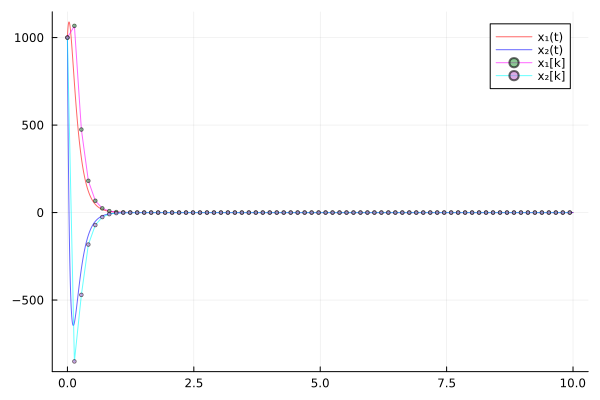

In [21]:
#plot_trajectories(xds[8], xc, hd, hc, T)

In [22]:
dev₁s = [dev₁ for dev₁ in dev₁_trajs[8]]
#plot(1:Hd, dev₁s, label="\$\\Delta x_1\$", lw=2)

72-element Vector{Float64}:
    0.0
 -326.4166796732353
 -162.404730054344
  -59.662539973592615
  -20.603679803223727
   -5.94090514635214
   -1.4515043466178943
   -0.2281727108526037
   -0.1676944137256482
   -0.30993770130960757
   -0.19640066763434658
   -0.07656462984484493
   -0.026572953950620013
    ⋮
   -1.1546134616447573e-19
   -1.2646507910957053e-19
   -5.600136078696109e-20
   -2.0984069982253468e-20
   -7.524376941546997e-21
   -2.59981767397235e-21
   -8.907504703127379e-22
   -3.0150079344869886e-22
   -1.0257072451629216e-22
   -3.502166837126211e-23
   -1.1905929717427073e-23
   -4.066133126394509e-24

In [12]:
#println("Trajectories that failed to converge:\n", [i for i in 1:N if isnothing(first_convergence([0.0, 0.0], xds[i], threshold=1e-2))])

In [13]:
#show(stdout, "text/plain", uds[5])

In [14]:
maximum(xd -> maximum(xd -> abs(xd[1]), xd), xds)

2975.6803263411357

In [15]:
maximum(ud -> maximum(ud -> abs(ud[1]), ud), uds)

2993.9555608220567

In [16]:
maximum(xc -> abs(xc[1]), xc)

1089.0862401887914

In [17]:
maximum(u -> abs(u[1]), uc)

2285.9891619269965